Bhavesh Bhatt

[**Link to my YouTube Channel**](https://www.youtube.com/BhaveshBhatt8791?sub_confirmation=1)

# Imports

In [98]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import accuracy_score
from sys import getsizeof

In [99]:
print(tf.__version__)

2.18.0


# Helper Functions

In [100]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [101]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

# Importa Data

In [102]:
import  pandas as pd

df = pd.read_csv("../dataset.csv", header=None)              # No header in your format
dataset = df.iloc[:, :-1].to_numpy(dtype=np.float32)            # All but last column as float16
labels_set = df.iloc[:, -1].to_numpy(dtype=str)                 # Last column as string

In [103]:
dataset = dataset.reshape(dataset.shape[0], 13, 16, 1)
input_shape = dataset[0].shape

print(f"Dataset shape: {dataset.shape}")
print(f"Labels shape: {labels_set.shape}")
print(f"Input shape: {input_shape}")

Dataset shape: (583554, 13, 16, 1)
Labels shape: (583554,)
Input shape: (13, 16, 1)


In [104]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(dataset, labels_set, test_size=0.2, random_state=42, stratify=labels_set)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Print the lengths of the training, validation, and testing sets.
print(f"Training set length: {len(x_train)}")
print(f"Validation set length: {len(x_val)}")
print(f"Testing set length: {len(x_test)}")

Training set length: 373474
Validation set length: 93369
Testing set length: 116711


In [105]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights.
class_weight = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
dist_class_weight = dict(enumerate(class_weight))

In [106]:
print(f"Classes: {np.unique(labels_set)}")

Classes: ['Background_noise' 'Bus' 'Car' 'Motorcycle' 'Truck']


In [107]:
print(f"Class weights: {dist_class_weight}")

Class weights: {0: np.float64(2.303546536729785), 1: np.float64(0.8562873290458667), 2: np.float64(0.8566506869738744), 3: np.float64(0.9921999946866449), 4: np.float64(0.8177576334833208)}


In [108]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Hot end code the labels.
label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(y_train))
y_test = to_categorical(label_encoder.fit_transform(y_test))
y_val = to_categorical(label_encoder.fit_transform(y_val))

## Build & Compile the model


In [109]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

model = keras.Sequential([
    InputLayer(shape=input_shape),  # 25 frames, 16 channels

    Conv2D(filters=16, kernel_size=5, activation="relu", padding='same', kernel_regularizer=l2(0.001)),
    Conv2D(filters=16, kernel_size=5, activation="relu", padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=2),
    
    Conv2D(filters=32, kernel_size=3, activation="relu", padding='same', kernel_regularizer=l2(0.001)),
    Conv2D(filters=32, kernel_size=3, activation="relu", padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=2),

    # Feature Pooling (Combining Max & Average Pooling)
    Flatten(),

    # Fully Connected Layer
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.4),  # Dropout slightly reduced for stability

    # Output Layer (Softmax for multi-class classification)
    Dense(units=len(np.unique(labels_set)), activation="softmax") # Softmax barely increase size.
])

In [110]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 13, 16, 16)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 13, 16, 16)     │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 6, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 6, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 6, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 3, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │        12,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,205 (129.71 KB)

 Trainable params: 33,205 (129.71 KB)

 Non-trainable params: 0 (0.00 B)

In [111]:
# Print training history
# Function used for printing two plots, one for accuracy and one for loss.
# To be used with the history object from the fit method
def printHistory(history):
  # Collect the number of epochs run based on the amount of loss value under history.
  epochs = len(history.history['loss'])

  epochrange = range(1, epochs + 1)
  train_acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.plot(epochrange, train_acc, 'bo', label='Training acc')
  plt.plot(epochrange, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochrange, train_loss, 'bo', label='Training loss')
  plt.plot(epochrange, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [112]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

# Fit model function used for convinience when fitting the model multiple times
def fitModel(model, x_train, y_train, x_val, y_val, epochs, doPrintHistory, class_weight, verbose, batch_size):

    # Define early stopping callback.
    reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        verbose=verbose,
        class_weight=class_weight,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr_on_plateau],
    )
    # Print history
    if doPrintHistory: printHistory(history)

In [113]:
def compileModel(model, learning_rate = 0.001):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['categorical_accuracy']
    )
    model.summary()

In [114]:
compileModel(model)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 13, 16, 16)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 13, 16, 16)     │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 6, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 6, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 6, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 3, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │        12,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,205 (129.71 KB)

 Trainable params: 33,205 (129.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32


/home/fridh/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2025-03-19 19:32:05.476175: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,16,13,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,16,13,16]{3,2,1,0}, f32[16,16,5,5]{3,2,1,0}, f32[16]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-19 19:32:05.505726: I external/local_xla/xla/service/gpu/autot

5833/5836 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.3481 - loss: 1.4227

2025-03-19 19:32:27.842350: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[34,16,13,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[34,16,13,16]{3,2,1,0}, f32[16,16,5,5]{3,2,1,0}, f32[16]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-19 19:32:27.884987: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[34,32,6,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[34,16,6,8]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationFor

5836/5836 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.3482 - loss: 1.4226

2025-03-19 19:32:29.930195: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,16,13,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,16,13,16]{3,2,1,0}, f32[16,16,5,5]{3,2,1,0}, f32[16]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-19 19:32:29.960456: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,32,6,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,16,6,8]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationFor

5836/5836 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - categorical_accuracy: 0.3482 - loss: 1.4226 - val_categorical_accuracy: 0.4061 - val_loss: 1.3299 - learning_rate: 0.0010
Epoch 2/32
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - categorical_accuracy: 0.3962 - loss: 1.2429 - val_categorical_accuracy: 0.4146 - val_loss: 1.3101 - learning_rate: 0.0010
Epoch 3/32
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - categorical_accuracy: 0.4078 - loss: 1.2243 - val_categorical_accuracy: 0.4241 - val_loss: 1.3085 - learning_rate: 0.0010
Epoch 4/32
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - categorical_accuracy: 0.4110 - loss: 1.2171 - val_categorical_accuracy: 0.4259 - val_loss: 1.3064 - learning_rate: 0.0010
Epoch 5/32
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - categorical_accuracy: 0.4124 - loss: 1.2123 - val_categorical_accuracy: 0.4256 - val_loss: 1.2914 - learning_rate: 0.0010
Epoch 6/32
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - categorical_accuracy: 0.4156 - loss: 1.2061 - val_categoric

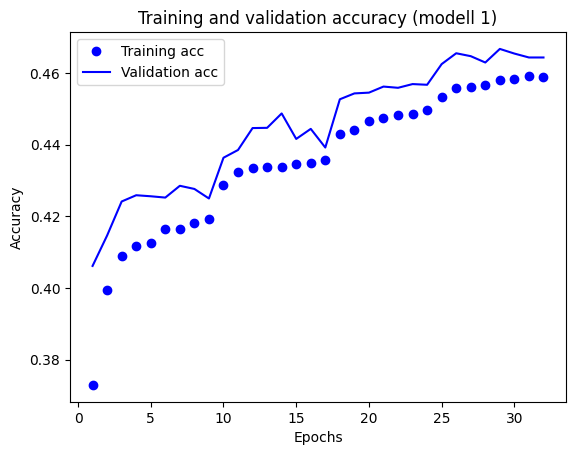

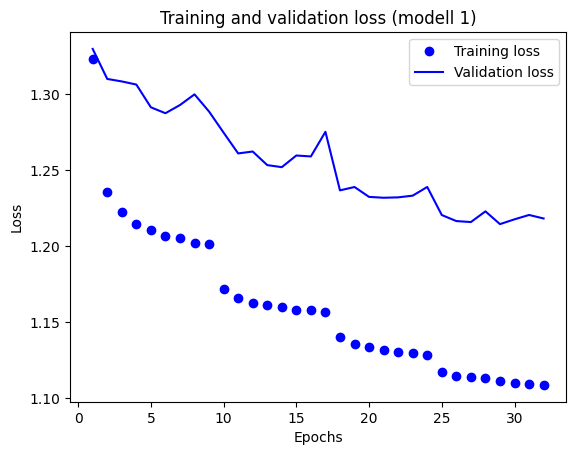

In [115]:
fitModel(model, x_train, y_train, x_val, y_val, 32, True, dist_class_weight, 1, 64)

In [116]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print('\nTest accuracy is {}%'.format(round(100*test_acc, 2)))

2025-03-19 19:45:13.091704: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,16,13,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,13,16]{3,2,1,0}, f32[16,1,5,5]{3,2,1,0}, f32[16]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-19 19:45:13.111060: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,16,13,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,16,13,16]{3,2,1,0}, f32[16,16,5,5]{3,2,1,0}, f32[16]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationF

3648/3648 - 9s - 3ms/step - categorical_accuracy: 0.4671 - loss: 1.2146

Test accuracy is 46.71%


In [117]:
KERAS_MODEL_NAME = "tf_model_mini.h5"
model.save(KERAS_MODEL_NAME)
convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")
keras_model_size = get_file_size(KERAS_MODEL_NAME)

File size: 0.434 Megabytes


# TF Lite Model

In [118]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"

In [119]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp58uj78dz/assets


INFO:tensorflow:Assets written to: /tmp/tmp58uj78dz/assets


Saved artifact at '/tmp/tmp58uj78dz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 13, 16, 1), dtype=tf.float32, name='keras_tensor_179')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  134114000261312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134114000263424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134114000259552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134114000261488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134114000268704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134114000261136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134114000270288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134114000266416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134114000267472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134114000270640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134114000267

W0000 00:00:1742409922.848986   20512 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1742409922.849006   20512 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-03-19 19:45:22.849214: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp58uj78dz
2025-03-19 19:45:22.850121: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-19 19:45:22.850138: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp58uj78dz
2025-03-19 19:45:22.858461: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-19 19:45:22.899251: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp58uj78dz
2025-03-19 19:45:22.912035: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 62823 microseconds.


In [120]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

137080

In [121]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

File size: 133.867 Kilobytes


In [122]:
tflite_file_size = get_file_size(TF_LITE_MODEL_FILE_NAME)

# Check Input Tensor Shape

In [123]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 13 16  1]
Input Type: <class 'numpy.float32'>
Output Shape: [1 5]
Output Type: <class 'numpy.float32'>


In [124]:
# Load your existing model
model = tf.keras.models.load_model('tf_model_mini.h5')

# Convert the model to TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.uint8]

# Ensure that the input and output types are uint8
def representative_dataset_gen():
    for i in range(len(x_test)):
        # Get sample input data as a numpy array in a method of your choosing
        yield [x_test[i]]

converter.representative_dataset = representative_dataset_gen
tflite_quant_model = converter.convert()

# Save the quantized model
with open('pipeline_int8_model_data.tflite', 'wb') as f:
    f.write(tflite_quant_model)


INFO:tensorflow:Assets written to: /tmp/tmpld8hf05k/assets


INFO:tensorflow:Assets written to: /tmp/tmpld8hf05k/assets


Saved artifact at '/tmp/tmpld8hf05k'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 13, 16, 1), dtype=tf.float32, name='input_layer_7')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  134113991902304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134113991907232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134113991914448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134113991919568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134113991927136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134113991927840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134113991933472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134113991930128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134113991962192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134113991960256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134113991966240

W0000 00:00:1742409924.051295   20512 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1742409924.051320   20512 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-03-19 19:45:24.051589: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpld8hf05k
2025-03-19 19:45:24.052918: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-19 19:45:24.052944: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpld8hf05k
2025-03-19 19:45:24.061029: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-19 19:45:24.105660: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpld8hf05k
2025-03-19 19:45:24.121249: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 69664 microseconds.


In [125]:
# Load and test the quantized model
interpreter = tf.lite.Interpreter(model_path='pipeline_int8_model_data.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the TensorFlow Lite model on random data from x_test
input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']

# Test the TensorFlow Lite model on random data from x_test
input_data = x_test[np.random.choice(x_test.shape[0], 1)]
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

print("TensorFlow Lite model output:", tflite_results)

TensorFlow Lite model output: [[0.02191332 0.37177888 0.2937511  0.09997737 0.21257934]]


In [126]:
!xxd -i pipeline_int8_model_data.tflite > pipeline_int8_model_data.cpp

In [127]:
# Print size of pipeline_int8_model_data.cpp
convert_bytes(get_file_size('pipeline_int8_model_data.cpp'), "KB")

File size: 825.577 Kilobytes
